# <center> cs231. Assignment 2.

Goal is to build neural network with linear layers to work on CIFAR-10 dataset. There is my own implementation, which I will double check with PyTorch.

## Importing libs

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt

import sys
import os
import glob
import pickle

# ================================================

if not '..' in sys.path:
    sys.path = ['..'] + sys.path
    
from _cs231n.neural_nets import layers, models
from _cs231n.metrics import accuracy

PATH_TO_DATA = '../data/cifar-10-batches-py'

## Loading & visualizing dataset

Dataset has been previously downloaded from [here](https://www.cs.toronto.edu/~kriz/cifar.html). There is a script `get_data.sh` in `assignment1` folder for this. Dataset is already split into train and test.

In [2]:
X_train0 = []
y_train0 = []

for fname in glob.glob(os.path.join(PATH_TO_DATA, 'data_batch_*')):
    with open(fname, 'rb') as fh:
        batch = pickle.load(fh, encoding='bytes')
        
    X_train0.append(batch[b'data'])
    y_train0 += batch[b'labels']
    
X_train0 = np.vstack(X_train0).astype(np.float64)/255
X_train0 = X_train0.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
y_train0 = np.array(y_train0)
print('Training data shape: {0}x{1}'.format(*X_train0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'test_batch'), 'rb') as fh:
    batch = pickle.load(fh, encoding='bytes')
    
    X_test0 = batch[b'data'].astype(np.float64)/255
    X_test0 = X_test0.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
    y_test0 = batch[b'labels']
    
print('Test data shape: {0}x{1}'.format(*X_test0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'batches.meta'), 'rb') as fh:
    categories_meta = pickle.load(fh, encoding='bytes')
    categories = [x.decode('UTF-8') for x in categories_meta[b'label_names']]
    
# ================================================
    
X_mean = X_train0.mean(axis=(0, 1, 2))
X_std = X_train0.reshape(X_train0.shape[0], 3, -1).std(axis=(0, 2))

X_train_norm = (X_train0 - X_mean[None, None, None, :])/X_std[None, None, None, :]
X_test_norm = (X_test0 - X_mean[None, None, None, :])/X_std[None, None, None, :]

Training data shape: 50000x32
Test data shape: 10000x32


Let's visualize dataset to see what we're dealing with. There are 10 categories of images, we will display several pics from each category.

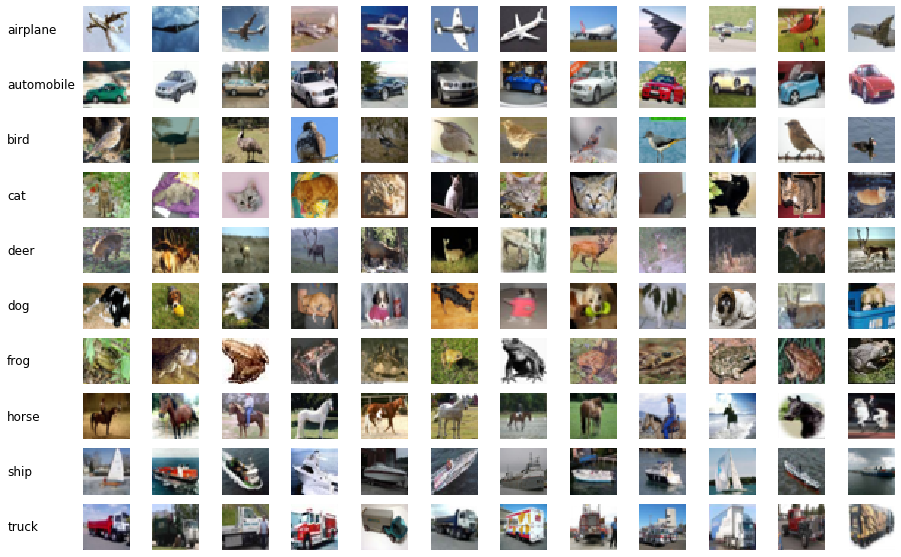

In [3]:
n_imgs = 12
labels = np.unique(y_train0)

fig0, axs = plt.subplots(nrows=len(labels), ncols=n_imgs + 1, figsize=(16, len(labels)))
for (xlabel, xcat, xaxs) in zip(labels, categories, axs):
    xaxs[0].text(0, 0.5, xcat, fontsize=12, va='center')
    xaxs[0].axis('off')
    idxs = np.random.choice(np.argwhere(y_train0 == xlabel).ravel(), n_imgs, replace=False)
    
    for (idx, xax) in zip(idxs, xaxs[1:]):
        xax.imshow(X_train0[idx])
        xax.set_aspect('equal')
        xax.axis('off')

Ok, due to low resolution some pics are pretty hard to get, even for human eye. Hope that neural net will do better than me.

As usual, we pick some data randomly from training set to serve as validation data.

In [4]:
val_part = 0.25
val_num = int(val_part*X_train0.shape[0])
tot_idxs = np.random.permutation(np.arange(X_train0.shape[0]))

val_idxs = tot_idxs[:val_num]
train_idxs = tot_idxs[val_num:]

## Model 1.

We start from a simple model - fully connected layer followed by ReLU non-linearity followed by another fully connected layer. Initialize the model and see what loss it gives without any training.

In [51]:
model1 = models.SequentialModel(
    layers=[
        # 32 x 32 x 3
        layers.Conv2D('Conv1', channels_in=3, channels_out=4, 
                      filter_size=3, stride=1, padding=1), 
        # 32 x 32 x 4
        layers.MaxPooling2D('MaxPool1', pool_size=2, stride=2), 
        # 16 x 16 x 4
        layers.Resizer('Flattener', shape_in=(16, 16, 4), shape_out=(1024, )), 
        # 1024
        layers.DenseLayer('FC1', features_in=1024, features_out=128, include_bias=True, 
                          reg_coef=1e-2), 
        # 128
        layers.ReLU('ReLU1'), 
        layers.DenseLayer('FC2', features_in=128, features_out=len(labels), include_bias=True, 
                          reg_coef=1e-2)
    ]
)

pred0, _, loss0, _ = model1.predict(X_train0, y_train0, batch_size=128)
print('Initial loss on training set : {0:.3f}'.format(loss0))
print('Initial accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0, pred0)))

Initial loss on training set : 2.303
Initial accuracy on training set: 11.63%


Indeed, we reached $100\%$ accuracy on small dataset. Let's proceed to training.

### Training

In [52]:
tr_loss, val_loss, val_acc = models.train_SGD(model1, models.softmax_predict, 
    X_train0[train_idxs], y_train0[train_idxs], X_train0[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=1e-2, epochs=24, 
    lr_decrease_coef=0.8, lr_decrease_step=3, momentum=0.9, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/24...
Learning rate: 0.01


Epoch is over. Training loss: 2.1255465612220856
Validation loss: 1.9976174425566444
Validation metric: 0.28704

--------------------------------

Epoch 2/24...
Learning rate: 0.01


Epoch is over. Training loss: 1.933569626288597
Validation loss: 1.8955602641091054
Validation metric: 0.33208

--------------------------------

Epoch 3/24...
Learning rate: 0.01


Epoch is over. Training loss: 1.863345702467867
Validation loss: 1.8446731210488727
Validation metric: 0.34536

--------------------------------

Epoch 4/24...
Learning rate: 0.008


Epoch is over. Training loss: 1.8187355027037242
Validation loss: 1.813353725662605
Validation metric: 0.3628

--------------------------------

Epoch 5/24...
Learning rate: 0.008


Epoch is over. Training loss: 1.7848679401652243
Validation loss: 1.7900183692606113
Validation metric: 0.37216

--------------------------------

Epoch 6/24...
Learning rate: 0.008


Epoch is over. Training loss: 1.7532887842911546
Validation loss: 1.7558622153076768
Validation metric: 0.37968

--------------------------------

Epoch 7/24...
Learning rate: 0.0064


Epoch is over. Training loss: 1.722813909699893
Validation loss: 1.720458294502137
Validation metric: 0.3976

--------------------------------

Epoch 8/24...
Learning rate: 0.0064


Epoch is over. Training loss: 1.7001278595398481
Validation loss: 1.7022005325613327
Validation metric: 0.40376

--------------------------------

Epoch 9/24...
Learning rate: 0.0064


Epoch is over. Training loss: 1.6796215714855045
Validation loss: 1.6941558145965105
Validation metric: 0.39688

--------------------------------

Epoch 10/24...
Learning rate: 0.00512


Epoch is over. Training loss: 1.6577310288720926
Validation loss: 1.6701453634346957
Validation metric: 0.41104

--------------------------------

Epoch 11/24...
Learning rate: 0.00512


Epoch is over. Training loss: 1.643873488942166
Validation loss: 1.6547069662568392
Validation metric: 0.41744

--------------------------------

Epoch 12/24...
Learning rate: 0.00512


Epoch is over. Training loss: 1.6295260808814784
Validation loss: 1.6440590162103021
Validation metric: 0.4176

--------------------------------

Epoch 13/24...
Learning rate: 0.004096000000000001


Epoch is over. Training loss: 1.6138323238203138
Validation loss: 1.6292314335406453
Validation metric: 0.42352

--------------------------------

Epoch 14/24...
Learning rate: 0.004096000000000001


Epoch is over. Training loss: 1.6036016850435573
Validation loss: 1.6253437571388694
Validation metric: 0.42768

--------------------------------

Epoch 15/24...
Learning rate: 0.004096000000000001


Epoch is over. Training loss: 1.5921993600945596
Validation loss: 1.6137188365251354
Validation metric: 0.42896

--------------------------------

Epoch 16/24...
Learning rate: 0.0032768000000000007


Epoch is over. Training loss: 1.5818271348573312
Validation loss: 1.6006702505852155
Validation metric: 0.4356

--------------------------------

Epoch 17/24...
Learning rate: 0.0032768000000000007


Epoch is over. Training loss: 1.5732060146546367
Validation loss: 1.597755149049601
Validation metric: 0.43736

--------------------------------

Epoch 18/24...
Learning rate: 0.0032768000000000007


Epoch is over. Training loss: 1.5663486869957803
Validation loss: 1.5973212911572243
Validation metric: 0.4384

--------------------------------

Epoch 19/24...
Learning rate: 0.002621440000000001


Epoch is over. Training loss: 1.5574121287588714
Validation loss: 1.585285078376892
Validation metric: 0.4416

--------------------------------

Epoch 20/24...
Learning rate: 0.002621440000000001


Epoch is over. Training loss: 1.5517390791076315
Validation loss: 1.5801635832621757
Validation metric: 0.44376

--------------------------------

Epoch 21/24...
Learning rate: 0.002621440000000001


Epoch is over. Training loss: 1.5466873060431692
Validation loss: 1.5781169217342927
Validation metric: 0.44192

--------------------------------

Epoch 22/24...
Learning rate: 0.002097152000000001


Epoch is over. Training loss: 1.540379806414338
Validation loss: 1.5725951335840542
Validation metric: 0.44448

--------------------------------

Epoch 23/24...
Learning rate: 0.002097152000000001


Epoch is over. Training loss: 1.5358846968501352
Validation loss: 1.5714869351378546
Validation metric: 0.44712

--------------------------------

Epoch 24/24...
Learning rate: 0.002097152000000001


Epoch is over. Training loss: 1.5318309595779527
Validation loss: 1.562289738076727
Validation metric: 0.45008

--------------------------------



All right, we reached some good progress here - $42.8\%$ accuracy is much better than random guessing! Let's see the training history.

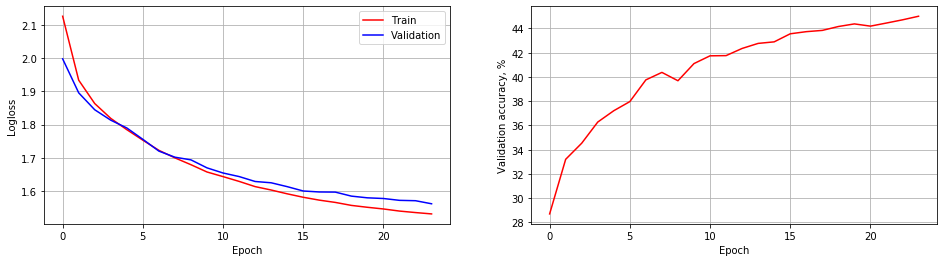

In [53]:
visualize_training(tr_loss, val_loss, val_acc)

Looks decent - both losses are falling down, no sign of overfitting. Perhaps we can even train a bit more and get additional $1\%$ accuracy.

## Model 2. Two-layered network with batch normalization.

It is well known that batch normalization is a very good technique to speed up training. Let's see if it can help us here. We're inserting BatchNorm after first fully connected layer.

In [55]:
model2 = models.SequentialModel(
    layers=[
        # 32 x 32 x 3
        layers.Conv2D('Conv1', channels_in=3, channels_out=8, 
                      filter_size=3, stride=1, padding=1), 
        # 32 x 32 x 8
        layers.MaxPooling2D('MaxPool1', pool_size=2, stride=2), 
        # 16 x 16 x 8
        layers.ReLU('ReLU1'), 
        layers.BatchNorm('BN1'), 
        layers.Dropout('Drop1', p_drop=0.1), 
        layers.Conv2D('Conv2', channels_in=8, channels_out=16, 
                      filter_size=3, stride=1, padding=1), 
        # 16 x 16 x 16
        layers.MaxPooling2D('MaxPool2', pool_size=2, stride=2), 
        layers.ReLU('ReLU2'), 
        layers.BatchNorm('BN2'), 
        layers.Dropout('Drop2', p_drop=0.1), 
        # 8 x 8 x 16
        layers.Resizer('Flattener', shape_in=(8, 8, 16), shape_out=(1024, )), 
        # 1024
        layers.DenseLayer('FC1', features_in=1024, features_out=128, include_bias=True, 
                          reg_coef=1e-3), 
        layers.ReLU('ReLU3'), 
        layers.BatchNorm('BN3'), 
        layers.Dropout('Drop3', p_drop=0.5), 
        # 128
        layers.DenseLayer('FC2', features_in=128, features_out=len(labels), include_bias=True, 
                          reg_coef=1e-3)
    ]
)

It might also be a good idea to normalize data as well. Remember that we're actually dealing with images here. Let's calculate mean and std for each of three color channels and use it for normalization.

Ok, checking how model has initialized.

In [56]:
pred0, _, loss0, _ = model2.predict(X_train_norm, y_train0)
print('Loss on training set : {0:.3f}'.format(loss0))
print('Accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0, pred0)))

Loss on training set : 3.073
Accuracy on training set: 9.52%


Boy, the loss again is higher than expected. Again unfortunate initialization?
Let's train the model.

In [57]:
tr_loss, val_loss, val_acc = models.train_SGD(model2, models.softmax_predict, 
    X_train0[train_idxs], y_train0[train_idxs], X_train0[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=1e-2, epochs=24, 
    lr_decrease_coef=0.8, lr_decrease_step=3, momentum=0.9, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/24...
Learning rate: 0.01


Epoch is over. Training loss: 2.164141999425073
Validation loss: 1.876344839193225
Validation metric: 0.33872

--------------------------------

Epoch 2/24...
Learning rate: 0.01


Epoch is over. Training loss: 1.861109882611117
Validation loss: 1.66025480849438
Validation metric: 0.40592

--------------------------------

Epoch 3/24...
Learning rate: 0.01


Epoch is over. Training loss: 1.733060818622185
Validation loss: 1.556338972033969
Validation metric: 0.44016

--------------------------------

Epoch 4/24...
Learning rate: 0.008


Epoch is over. Training loss: 1.6466842989703256
Validation loss: 1.5075359437201434
Validation metric: 0.45528

--------------------------------

Epoch 5/24...
Learning rate: 0.008


Epoch is over. Training loss: 1.6025444787743095
Validation loss: 1.5150354098539809
Validation metric: 0.44704

--------------------------------

Epoch 6/24...
Learning rate: 0.008


Epoch is over. Training loss: 1.5591976698959311
Validation loss: 1.4318818545204541
Validation metric: 0.48224

--------------------------------

Epoch 7/24...
Learning rate: 0.0064


Epoch is over. Training loss: 1.516376486506654
Validation loss: 1.3836268837508605
Validation metric: 0.49968

--------------------------------

Epoch 8/24...
Learning rate: 0.0064


Epoch is over. Training loss: 1.4803578417765733
Validation loss: 1.35951557529238
Validation metric: 0.51088

--------------------------------

Epoch 9/24...
Learning rate: 0.0064


Epoch is over. Training loss: 1.4593952564472732
Validation loss: 1.3380160773306549
Validation metric: 0.51824

--------------------------------

Epoch 10/24...
Learning rate: 0.00512


Epoch is over. Training loss: 1.4319524329054565
Validation loss: 1.3113251913740567
Validation metric: 0.52816

--------------------------------

Epoch 11/24...
Learning rate: 0.00512


Epoch is over. Training loss: 1.4120152839895646
Validation loss: 1.2991906495263197
Validation metric: 0.53104

--------------------------------

Epoch 12/24...
Learning rate: 0.00512


Epoch is over. Training loss: 1.3976255132652424
Validation loss: 1.2823908422904153
Validation metric: 0.53704

--------------------------------

Epoch 13/24...
Learning rate: 0.004096000000000001


Epoch is over. Training loss: 1.3766577927030774
Validation loss: 1.2684797447300202
Validation metric: 0.54472

--------------------------------

Epoch 14/24...
Learning rate: 0.004096000000000001


Epoch is over. Training loss: 1.369663611064315
Validation loss: 1.267509891937732
Validation metric: 0.542

--------------------------------

Epoch 15/24...
Learning rate: 0.004096000000000001


Epoch is over. Training loss: 1.357248965772596
Validation loss: 1.2833006775557305
Validation metric: 0.5432

--------------------------------

Epoch 16/24...
Learning rate: 0.0032768000000000007


Epoch is over. Training loss: 1.349725646253972
Validation loss: 1.2448536801664938
Validation metric: 0.55448

--------------------------------

Epoch 17/24...
Learning rate: 0.0032768000000000007


Epoch is over. Training loss: 1.342508697004885
Validation loss: 1.2323026662924452
Validation metric: 0.55984

--------------------------------

Epoch 18/24...
Learning rate: 0.0032768000000000007


Epoch is over. Training loss: 1.328999760919442
Validation loss: 1.2379990003601087
Validation metric: 0.5536

--------------------------------

Epoch 19/24...
Learning rate: 0.002621440000000001


Epoch is over. Training loss: 1.32207822157035
Validation loss: 1.218208146108781
Validation metric: 0.56528

--------------------------------

Epoch 20/24...
Learning rate: 0.002621440000000001


Epoch is over. Training loss: 1.3133438152587118
Validation loss: 1.2122357087848035
Validation metric: 0.56608

--------------------------------

Epoch 21/24...
Learning rate: 0.002621440000000001


Epoch is over. Training loss: 1.307171430811748
Validation loss: 1.2018643309342039
Validation metric: 0.56976

--------------------------------

Epoch 22/24...
Learning rate: 0.002097152000000001


Epoch is over. Training loss: 1.3011882115070736
Validation loss: 1.1978372076451065
Validation metric: 0.57304

--------------------------------

Epoch 23/24...
Learning rate: 0.002097152000000001


Epoch is over. Training loss: 1.296388930707046
Validation loss: 1.191969695461522
Validation metric: 0.5748

--------------------------------

Epoch 24/24...
Learning rate: 0.002097152000000001


Epoch is over. Training loss: 1.2937459766341766
Validation loss: 1.1889810507987433
Validation metric: 0.57712

--------------------------------



We got significant improvement over last model: more than $50\%$ accuracy. However, losses on training and validation sets are very different, so we might have overfitted.

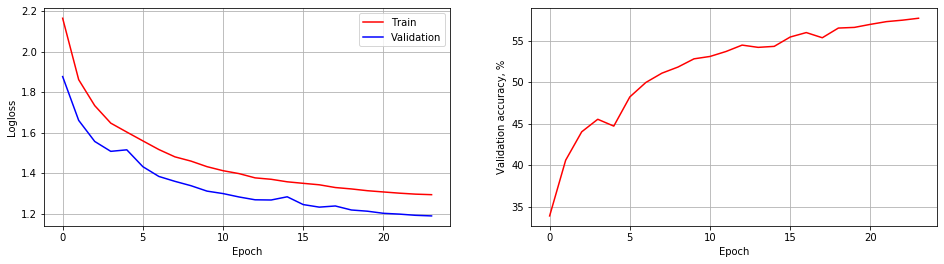

In [58]:
visualize_training(tr_loss, val_loss, val_acc)

Yep, classical overfitting here. The graph says that we even hit more that $51\%$ accuracy somewhere around epoch 15, but then things got worse. We need more regularization.

## Model 3. Additional hidden layer + dropout.

Another cool regularization technique is dropout. We apply this, but also complicate model a little - by inserting another fully connected layer.

In [12]:
model3 = models.SequentialModel(
    layers=[
        # 32 x 32 x 3
        layers.Conv2D('Conv1', channels_in=3, channels_out=8, 
                      filter_size=3, stride=1, padding=1), 
        # 32 x 32 x 8
        layers.ReLU('ReLU1'), 
        layers.BatchNorm('BN1'), 
        layers.Dropout('Drop1', p_drop=0.15), 
        # ----------------
        layers.Conv2D('Conv2', channels_in=8, channels_out=16, 
                      filter_size=6, stride=2, padding=0), 
        # 14 x 14 x 16
        layers.ReLU('ReLU2'), 
        layers.BatchNorm('BN2'), 
        layers.Dropout('Drop2', p_drop=0.15), 
        # ----------------
        layers.Conv2D('Conv3', channels_in=16, channels_out=16, 
                      filter_size=3, stride=1, padding=1), 
        # 14 x 14 x 16
        layers.ReLU('ReLU3'), 
        layers.BatchNorm('BN3'), 
        layers.Dropout('Drop3', p_drop=0.15), 
        # ----------------
        layers.Conv2D('Conv4', channels_in=16, channels_out=64, 
                      filter_size=4, stride=2, padding=0), 
        # 6 x 6 x 64
        layers.ReLU('ReLU4'), 
        layers.BatchNorm('BN4'), 
        layers.Dropout('Drop4', p_drop=0.15), 
        # ----------------
        layers.AveragePooling2D('AvgPool1', pool_size=4, stride=2), 
        # 2 x 2 x 64
        layers.Resizer('Flattener', shape_in=(2, 2, 64), shape_out=(256, )), 
        # 256
        layers.DenseLayer('FC1', features_in=256, features_out=64, include_bias=True, 
                          reg_coef=1e-3), 
        # 64
        layers.ReLU('ReLU6'), 
        layers.BatchNorm('BN6'), 
        layers.Dropout('Drop6', p_drop=0.5), 
        layers.DenseLayer('FC2', features_in=64, features_out=len(labels), include_bias=True, 
                          reg_coef=1e-3)
    ]
)

Ok, checking on raw data.

In [13]:
pred0, _, loss0, _ = model3.predict(X_train_norm, y_train0)
print('Loss on training set : {0:.3f}'.format(loss0))
print('Accuracy on training set: {0:.2f}%'.format(100*accuracy(y_train0, pred0)))

Loss on training set : 2.894
Accuracy on training set: 12.24%


Something must be really off with initialization. Initial loss again is higher noticeably.

On to training.

In [14]:
tr_loss, val_loss, val_acc = models.train_SGD(model3, models.softmax_predict, 
    X_train_norm[train_idxs], y_train0[train_idxs], X_train_norm[val_idxs], y_train0[val_idxs], 
    metric=accuracy, 
    lr=3e-3, epochs=30, 
    lr_decrease_coef=0.8, lr_decrease_step=3, momentum=0.9, 
    batch_size=128, show_progress=True, verbose=True)


--------------------------------

Epoch 1/30...
Learning rate: 0.003


Epoch is over. Training loss: 2.114927813071
Validation loss: 1.660294984126502
Validation metric: 0.4044

--------------------------------

Epoch 2/30...
Learning rate: 0.003


Epoch is over. Training loss: 1.753588572872905
Validation loss: 1.549934697185327
Validation metric: 0.45096

--------------------------------

Epoch 3/30...
Learning rate: 0.003


Epoch is over. Training loss: 1.6248348315689694
Validation loss: 1.4133701796753897
Validation metric: 0.50744

--------------------------------

Epoch 4/30...
Learning rate: 0.0024000000000000002


Epoch is over. Training loss: 1.538561453517063
Validation loss: 1.3302192052444763
Validation metric: 0.53664

--------------------------------

Epoch 5/30...
Learning rate: 0.0024000000000000002


Epoch is over. Training loss: 1.4853041637296507
Validation loss: 1.2831165514456908
Validation metric: 0.55208

--------------------------------

Epoch 6/30...
Learning rate: 0.0024000000000000002


Epoch is over. Training loss: 1.44508795712407
Validation loss: 1.2568548960728556
Validation metric: 0.55312

--------------------------------

Epoch 7/30...
Learning rate: 0.0019200000000000003


Epoch is over. Training loss: 1.4002588814010082
Validation loss: 1.2188534545039833
Validation metric: 0.57704

--------------------------------

Epoch 8/30...
Learning rate: 0.0019200000000000003


Epoch is over. Training loss: 1.3760704495940461
Validation loss: 1.1798100290997355
Validation metric: 0.58648

--------------------------------

Epoch 9/30...
Learning rate: 0.0019200000000000003


Epoch is over. Training loss: 1.3484004189912664
Validation loss: 1.1709268986958725
Validation metric: 0.592

--------------------------------

Epoch 10/30...
Learning rate: 0.0015360000000000003


Epoch is over. Training loss: 1.3220063019775137
Validation loss: 1.1817298624673918
Validation metric: 0.57888

--------------------------------

Epoch 11/30...
Learning rate: 0.0015360000000000003


Epoch is over. Training loss: 1.2996943182276866
Validation loss: 1.1339110924086975
Validation metric: 0.60392

--------------------------------

Epoch 12/30...
Learning rate: 0.0015360000000000003


Epoch is over. Training loss: 1.2860661286150683
Validation loss: 1.115763489931869
Validation metric: 0.61

--------------------------------

Epoch 13/30...
Learning rate: 0.0012288000000000004


Epoch is over. Training loss: 1.2623641956920746
Validation loss: 1.1015889277404505
Validation metric: 0.6108

--------------------------------

Epoch 14/30...
Learning rate: 0.0012288000000000004


Epoch is over. Training loss: 1.257213297225994
Validation loss: 1.0886087968703406
Validation metric: 0.6168

--------------------------------

Epoch 15/30...
Learning rate: 0.0012288000000000004


Epoch is over. Training loss: 1.2493404368119891
Validation loss: 1.0865628287620506
Validation metric: 0.62032

--------------------------------

Epoch 16/30...
Learning rate: 0.0009830400000000003


Epoch is over. Training loss: 1.2294408629842297
Validation loss: 1.071641808108041
Validation metric: 0.622

--------------------------------

Epoch 17/30...
Learning rate: 0.0009830400000000003


Epoch is over. Training loss: 1.2266145601543295
Validation loss: 1.0702309133073933
Validation metric: 0.62296

--------------------------------

Epoch 18/30...
Learning rate: 0.0009830400000000003


Epoch is over. Training loss: 1.2167701871330028
Validation loss: 1.05723808030008
Validation metric: 0.62512

--------------------------------

Epoch 19/30...
Learning rate: 0.0007864320000000003


Epoch is over. Training loss: 1.2044884774034974
Validation loss: 1.0467511964133929
Validation metric: 0.63152

--------------------------------

Epoch 20/30...
Learning rate: 0.0007864320000000003


Epoch is over. Training loss: 1.1949328068592666
Validation loss: 1.0392486113940322
Validation metric: 0.6324

--------------------------------

Epoch 21/30...
Learning rate: 0.0007864320000000003


Epoch is over. Training loss: 1.1942115817296672
Validation loss: 1.033153592106596
Validation metric: 0.63728

--------------------------------

Epoch 22/30...
Learning rate: 0.0006291456000000003


Epoch is over. Training loss: 1.183233551306648
Validation loss: 1.0276173688764307
Validation metric: 0.63904

--------------------------------

Epoch 23/30...
Learning rate: 0.0006291456000000003


Epoch is over. Training loss: 1.1778617991483795
Validation loss: 1.0196799195313742
Validation metric: 0.63848

--------------------------------

Epoch 24/30...
Learning rate: 0.0006291456000000003


Epoch is over. Training loss: 1.1733739087429795
Validation loss: 1.0247537525528816
Validation metric: 0.63688

--------------------------------

Epoch 25/30...
Learning rate: 0.0005033164800000003


Epoch is over. Training loss: 1.1656145611258208
Validation loss: 1.0222268173619524
Validation metric: 0.64104

--------------------------------

Epoch 26/30...
Learning rate: 0.0005033164800000003


Epoch is over. Training loss: 1.162795176837591
Validation loss: 1.0162321693971055
Validation metric: 0.64336

--------------------------------

Epoch 27/30...
Learning rate: 0.0005033164800000003


Epoch is over. Training loss: 1.1621586833456752
Validation loss: 1.0058506845328794
Validation metric: 0.64696

--------------------------------

Epoch 28/30...
Learning rate: 0.0004026531840000003


Epoch is over. Training loss: 1.1498784045500394
Validation loss: 1.0076956115322904
Validation metric: 0.646

--------------------------------

Epoch 29/30...
Learning rate: 0.0004026531840000003


Epoch is over. Training loss: 1.1543408064636056
Validation loss: 1.003324237376542
Validation metric: 0.64848

--------------------------------

Epoch 30/30...
Learning rate: 0.0004026531840000003


Epoch is over. Training loss: 1.1433232145054075
Validation loss: 1.0016607508268591
Validation metric: 0.64936

--------------------------------



Dropout is working - our model is more powerful than previous one, yet overfitting here is much less severe (if there is any). Let's examine training history.

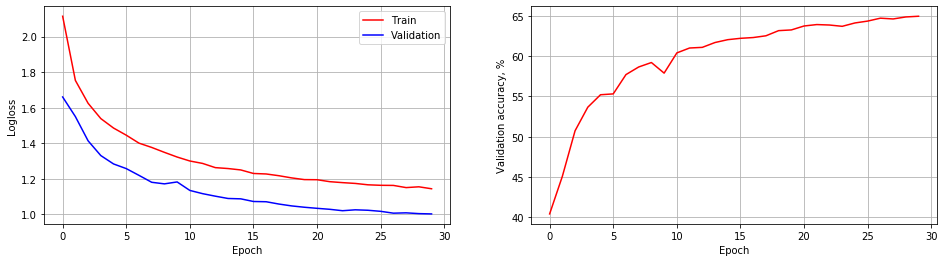

In [15]:
visualize_training(tr_loss, val_loss, val_acc)

Looks good with $51.1\%$ accuracy on validation set. However, the gap between training and validation losses is still high. Yet, I fear that if I continue training the overfitting will kick in. Let's increase dropout probability.

Same model as before, just higher dropout rate.